In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
from ipywidgets import interact, IntSlider
import sys
sys.path.append("../utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14

/Users/sgkang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# IP example: Gradient array with single source

### Linearization of induced polarization (IP) responses

$$ d^{IP} = F[\sigma(1-\eta)] - F[\sigma] $$
$$\simeq -\frac{\partial F[\sigma]}{\partial log(\sigma)} $$


- $F[\cdot]$: Static Maxwell's operator (taking $\sigma(x, y, z)$)

- $\eta$: Chargeability (ms or mV/V)

<img src="./images/DCIP_kimberlites.png" width=500> </img>

## Mesh and Chargeability model

In [2]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]
sigma = mesh.readModelUBC("VTKout_DC.dat")
eta = mesh.readModelUBC("VTKout_eta.dat")
airind = sigma == 1e-8

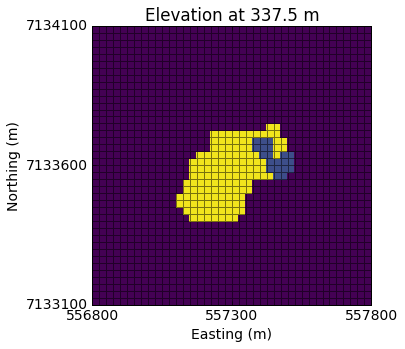

In [3]:
ax = viz(mesh, eta*1e3, 26, airind=airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(0, 1.6), label="Chargeability (ms)", cb=False)

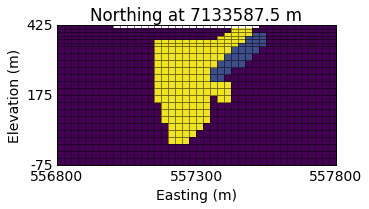

In [4]:
ax = viz(mesh, eta*1e3, 30, airind=airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(0, 1.6), label="Chargeability (ms)", cb=False)

## Obtain topographic surface from 3D conductivity model

In [5]:
mesh2D, topoCC = gettopoCC(mesh, airind)

## Gradient array for IP survey

In [6]:
# A source location (A-B electrodes, x-direction)
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)] 
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)] 
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]

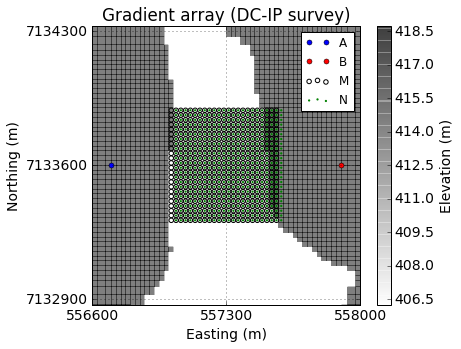

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5*1.2,5))
dat = mesh2D.plotImage(topoCC,pcolorOpts={"cmap":"binary",'alpha':0.5}, ax=ax)
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
cb = plt.colorbar(dat[0]); cb.set_label("Elevation (m)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'bo', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'ro', ms=5)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.axis('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")  
ax.set_title("Gradient array (DC-IP survey)")
ax.grid(True)
fig.savefig("./images/GradientArray", dpi=200)

In [8]:
# Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
src1 = DC.Src.Dipole([rx_x], Aloc1_x, Bloc1_x)

In [9]:
survey = DC.Survey([src1])
problem = DC.Problem3D_CC(mesh)
problem.Solver = MumpsSolver
problem.pair(survey)
f = problem.fields(sigma)
dobs = survey.dpred(sigma, f=f)

In [10]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

In [11]:
# Obtain estimated 3D conductivity from DC inversion
sigopt = np.load("sigest.npy")

## Compute true IP data

In [12]:
# Generate true IP data using true conductivity model
eta = mesh.readModelUBC("VTKout_eta.dat")
actmapIP = Maps.InjectActiveCells(mesh, ~airind, 0.)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigma, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src1])
problemIP.pair(surveyIP)
dataIP = surveyIP.dpred(eta[~airind])

## Use estimated $\sigma (x, y, z)$ to compute sensitivity 

In [13]:
# Use estimated conductivity model to compute sensitivity function
survey = DC.Survey([src1])
problem = DC.Problem3D_CC(mesh)
problem.Solver = MumpsSolver
problem.pair(survey)
f = problem.fields(sigopt)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigopt, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src1])
problemIP.pair(surveyIP)

In [14]:
ipdata = Survey.Data(surveyIP, v=dataIP)

In [15]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    ax.axis("equal")

    cb = plt.colorbar(dat, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
    cb.set_label("Potential (V)")
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    

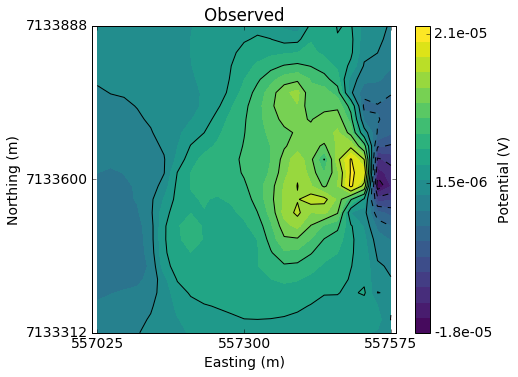

In [33]:
vizdata(ipdata, src1, rx_x, title="Observed", clim=(-1.8e-5, 2.1e-5))

(7133300.0, 7133900.0)

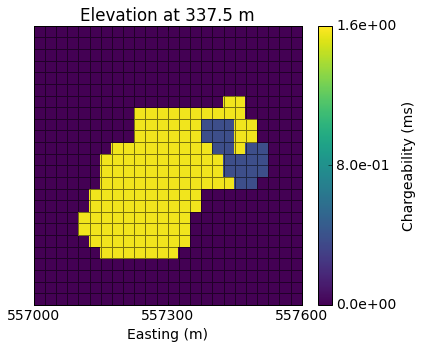

In [17]:
ax = viz(mesh, eta*1e3, 26, airind=airind, normal="Z", scale="linear", clim=(0, 1.6), label="Chargeability (ms)", xc=xc, yc=yc, zc=zc)
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks([]); ax.set_ylabel('')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


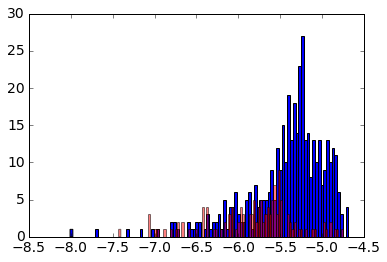

In [18]:
a = hist(np.log10(dataIP[dataIP>0.]), bins=100)
b = hist(np.log10(-dataIP[dataIP<0.]), bins=100, color='r', alpha=0.5)

## Depth weight

In [19]:
depth = 1./(abs(mesh.gridCC[:,2]-zc))**1.5
depth = depth/depth.max()

(-175.0, 425.0)

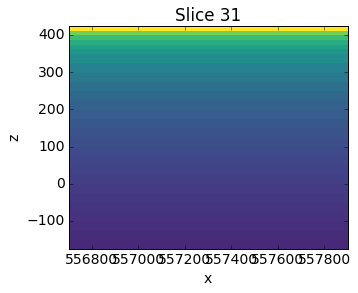

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax, pcolorOpts={"cmap":"viridis"})
ax.set_xlim(-600+xc, 600+xc)
ax.set_ylim(-600+zc, 0.+zc)    

## Sensitivity weight?

In [174]:
def matFun(v):
    y = problemIP.Jvec(m0, v, f=f)
    out = problemIP.Jtvec(m0, y, f=f)
    return out
weight_sense = np.sqrt(abs(Utils.diagEst(matFun, m0.size, k=2)))

In [179]:
abs(weight_sense).min()

0.00011488918194763998

In [180]:
weight = abs(weight_sense) / abs(weight_sense).max()
print np.log10(weight).min(), np.log10(weight).max()

-3.20440744945 0.0


In [181]:
print weight_sense.min(), weight_sense.max()

0.000114889181948 0.183944406713


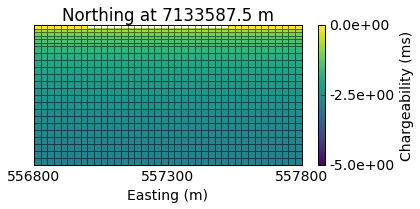

In [182]:
ax = viz(mesh, np.log10(depth), 30, airind=airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(-5, 0.), label="Chargeability (ms)")
ax.set_yticks([]); ax.set_ylabel('')

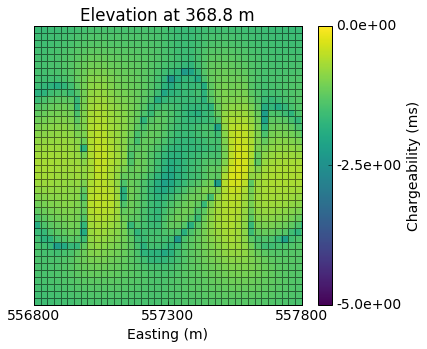

In [206]:
ax = viz(mesh, actmapIP*np.log10(weight), 28, airind=airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(-5, 0.), label="Chargeability (ms)")
ax.set_yticks([]); ax.set_ylabel('')

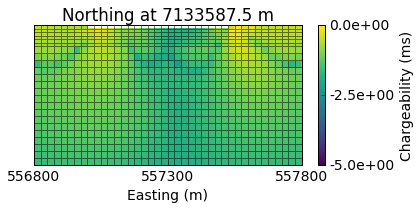

In [184]:
ax = viz(mesh, actmapIP*np.log10(weight), 30, airind=airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(-5, 0.), label="Chargeability (ms)")
ax.set_yticks([]); ax.set_ylabel('')

In [208]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
std = 0.
eps = abs(dataIP).max()*0.01
surveyIP.std = std
surveyIP.eps = eps
m0 = np.ones(mesh.nC)[~airind]*1e-20
regmap = Maps.IdentityMap(nP=m0.size)
#TODO put warning when dobs is not set!
surveyIP.dobs = dataIP
dmisfit = DataMisfit.l2_DataMisfit(surveyIP)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.wght = depth[~airind]
# reg.wght = weight
opt = Optimization.ProjectedGNCG(maxIter = 10)
opt.lower = 0.
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
# beta.beta = 10.
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, beta, save, target, savemodel])
reg.alpha_s = 1e-1
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problemIP.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mIPopt = inv.run(m0)
# problemIP.Ainv.clean()

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2016-07-03-23-08.txt'
SimPEG.SaveModelEveryIteration will save your models as: '###-InversionModel-2016-07-03-23-08.npy'
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.92e+06  2.76e+05  0.00e+00  2.76e+05    1.30e+08      0              
   1  1.92e+06  1.46e+05  3.06e-03  1.52e+05    9.84e+07      0              
   2  1.92e+06  5.71e+04  1.05e-02  7.73e+04    4.23e+07      0   Skip BFGS  
   3  3.85e+05  2.75e+04  1.45e-02  3.30e+04    1.79e+07      0   Skip BFGS  
   4  3.85e+05  1.32e+04  2.50e-02  2.2

In [209]:
XC = opt.recall('xc')

In [210]:
# dmisfit.eval(mIPopt)

In [211]:
# import pickle
# eta_pred = actmapIP*mIPopt
# Results = {"model_true":eta, "model_pred":eta_pred, "Obs":surveyIP.dobs, "Pred":invProb.dpred}
# outputs = open("IPresults", 'wb')
# pickle.dump(Results, outputs)
# outputs.close()

In [212]:
dpred = invProb.dpred
dobs = surveyIP.dobs

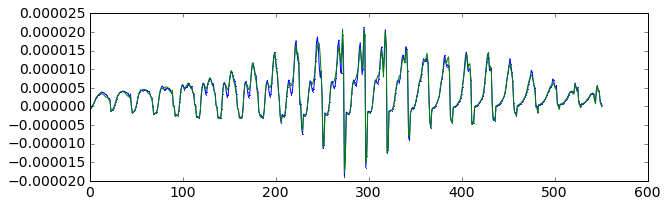

In [213]:
figsize(10, 3)
plt.plot(dpred, '.-', ms=1)
plt.plot(dobs)

In [214]:
ippred = Survey.Data(surveyIP, v=dpred)

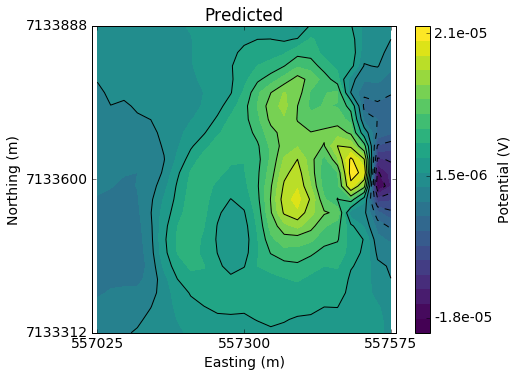

In [215]:
vizdata(ippred, src1, rx_x, title="Predicted", clim=(-1.8e-5, 2.1e-5))

In [216]:
from ipywidgets import interact, IntSlider

In [217]:
iteration = 10
eta_pred = actmapIP*mIPopt

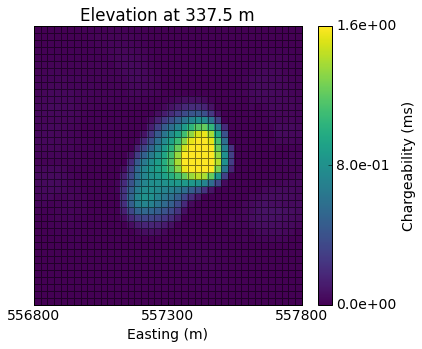

In [218]:
ax = viz(mesh, eta_pred*1e3, 26, airind=airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
ax.set_yticks([]); ax.set_ylabel('')

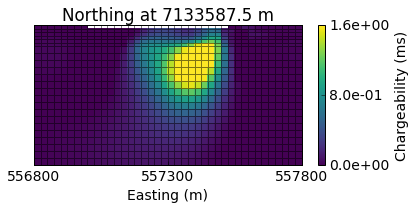

In [219]:
ax = viz(mesh, eta_pred*1e3, 30, airind=airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(0, 1.6), label="Chargeability (ms)")
ax.set_yticks([]); ax.set_ylabel('')
